In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

from MultiTreeGP.expression import Expression
import MultiTreeGP.evaluators.dynamic_evaluate as dynamic_evaluate
import MultiTreeGP.evaluators.feedforward_evaluate as ff_evaluate
from MultiTreeGP.algorithms.genetic_programming import GeneticProgramming
from MultiTreeGP.environments.control_environments.acrobot import Acrobot

key = jrandom.PRNGKey(1)

# Generate data

In [2]:
def get_data(key, env, batch_size, dt, T, param_setting):
    init_key, noise_key1, noise_key2, param_key = jrandom.split(key, 4)
    x0, targets = env.sample_init_states(batch_size, init_key)
    process_noise_keys = jrandom.split(noise_key1, batch_size)
    obs_noise_keys = jrandom.split(noise_key2, batch_size)
    ts = jnp.arange(0, T, dt)

    params = env.sample_params(batch_size, param_setting, ts, param_key)
    return x0, ts, targets, process_noise_keys, obs_noise_keys, params

init_key, data_key = jrandom.split(key)
batch_size = 32
T = 50
dt = 0.2
process_noise = 0.05
obs_noise = 0.1
param_setting = "Constant"

env = Acrobot(process_noise, obs_noise)

data = get_data(data_key, env, batch_size, dt, T, param_setting)

# Static Symbolic Policy Learning

In [3]:
#Define hyperparameters
population_size = 50
num_populations = 3
pool_size = 8
num_generations = 10
state_size = 2

#Define expressions
operators = ["+", "-", "*", "/", "power", "sin", "cos"]
operator_probs = jnp.array([0.5, 0.3, 0.5, 0.1, 0.1, 0.1, 0.1])

expressions = [Expression([["y",env.n_obs],["tar",env.n_targets]], operators, operator_probs)]
layer_sizes = jnp.array([env.n_control])

#Define evaluator
fitness_function = ff_evaluate.Evaluator(env, 0.002)

In [4]:
#Initialize strategy
strategy = GeneticProgramming(num_generations, population_size, fitness_function, expressions, layer_sizes, 
                        num_populations = num_populations, pool_size = pool_size, leaf_sd=3)

#Initialize population
population = strategy.initialize_population(init_key)

for g in range(num_generations):
    fitnesses, population = strategy.evaluate_population(population, data)
    
    best_fitness, best_solution = strategy.get_statistics(g)
    
    print(f"In generation {g+1}, best fitness = {best_fitness:.4f}, best solution = {best_solution}")

    if g < (num_generations-1):
        key, sample_key = jrandom.split(key)
        population = strategy.evolve_population(population, sample_key)

best_fitnesses, best_solutions = strategy.get_statistics()

In generation 1, best fitness = 165.1665, best solution = [-1.287*y2]
In generation 2, best fitness = 164.9912, best solution = [y3 + 0.466]
In generation 3, best fitness = 164.9912, best solution = [y3 + 0.466]
In generation 4, best fitness = 148.1570, best solution = [y0 + y1 + y3]
In generation 5, best fitness = 148.1570, best solution = [y0 + y1 + y3]
In generation 6, best fitness = 148.1570, best solution = [y0 + y1 + y3]
In generation 7, best fitness = 148.1570, best solution = [y0 + y1 + y3]
In generation 8, best fitness = 148.1570, best solution = [y0 + y1 + y3]
In generation 9, best fitness = 148.1570, best solution = [y0 + y1 + y3]
In generation 10, best fitness = 148.1570, best solution = [y0 + y1 + y3]


# Visualize best solution

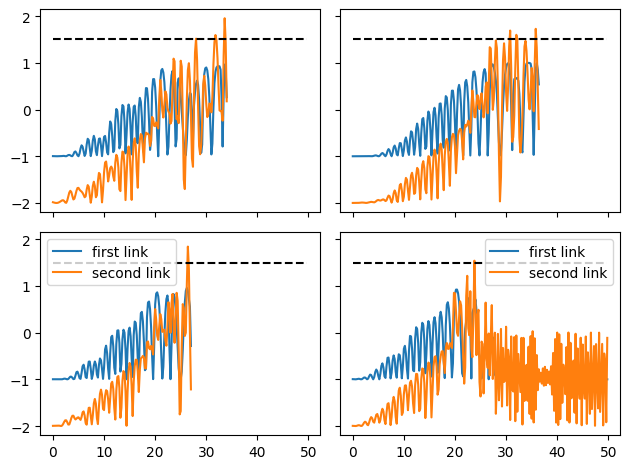

In [6]:
#Generate test_data
data = get_data(jrandom.PRNGKey(42), env, 4, dt, T, param_setting)
x0s, ts, targets, _, _, params = data

xs, ys, us, fitness = fitness_function.evaluate_model(best_solutions[-1].tree_to_function(expressions), data)

figure, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.ravel()

for i in range(4):
    ax[i].plot(ts, -jnp.cos(xs[i,:,0]), color = f"C{0}", label="first link")
    ax[i].plot(ts, -jnp.cos(xs[i,:,0]) - jnp.cos(xs[i,:,0] + xs[i,:,1]), color = f"C{1}", label="second link")
    ax[i].hlines(1.5, ts[0], ts[-1], linestyles='dashed', color = "black")

ax[-1].legend(loc="best")
ax[-2].legend(loc="best")
plt.tight_layout()
plt.show()